# Authorship Verification

In [1]:
import os
import re
from collections import Counter
import glob
from itertools import combinations, product

import lxml.etree
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import numpy as np
np.random.seed(18012023)
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scipy.spatial.distance as scidist

In [2]:
def load_verses(filepath, rm_interpol=True):    
    tree = lxml.etree.parse(filepath)
    
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
    
    verses = []
    
    for line_node in tree.iterfind('//l'):
        verse = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        verse.append(('n(prop)', 'n(prop)'))
                    else:
                        verse.append((l, p))
        
        verses.append(verse)
    
    return verses

In [3]:
fn = '../data/xml/vl-aiol.xml'
print(load_verses(fn)[:10])

[[('toen', 'adv(dem)'), ('het', 'pron(pers,3,sing)'), ('hij', 'pron(pers,3,sing)'), ('zeggen', 'v(fin,past,lex)'), ('zij', 'pron(pers,3,sing)'), ('altehand', 'adv(gener)')], [('dat', 'conj(subord)'), ('n(prop)', 'n(prop)'), ('zijn', 'v(fin,past,aux_cop)'), ('zijn', 'pron(poss)'), ('naam', 'n(sing)')], [('die', 'pron(rel)'), ('zijn', 'v(fin,past,aux_cop)'), ('de', 'art(def)'), ('heer', 'n(sing)'), ('niet', 'adv(neg)'), ('bekwaam', 'adj()')], [('hij', 'pron(pers,3,sing)'), ('worden', 'adv(gener)'), ('vervaren', 'v(participle,past)'), ('in', 'adp()'), ('aanzicht', 'art(def)'), ('het', 'n(sing)')], [('men', 'pron(indef)'), ('mogen', 'v(fin,past,aux_cop)'), ('niet', 'adv(neg)'), ('verblijden', 'v(infin)'), ('licht', 'adv(gener)')], [('toen', 'conj(subord)'), ('hij', 'pron(pers,3,sing)'), ('verstaan', 'v(fin,past,lex)'), ('dat', 'conj(subord)'), ('n(prop)', 'n(prop)'), ('zijn', 'v(fin,past,aux_cop)')], [('die', 'pron(rel)'), ('daar', 'adv(dem)'), ('staan', 'v(fin,past,lex)'), ('in', 'art(def

In [4]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['genre'] == 'Epiek']
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
85,Merlijn-Maerlant,Merlijn,Jacob van Maerlant,1425.0,cdrom-mnl,1415-1435,Epiek,Arthur,NaN
218,spiegel_historiael__2_fragm_ge1,Spiegel historiael (P2),Philip Utenbroeke,1400.0,cdrom-mnl,1390-1410,Epiek,Historiografie,NaN
11,bediedenisse_van_der_missen,Bediedenisse van der missen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Religie,NaN
105,lapidarijs,Lapidarijs,NaN,1350.0,cdrom-mnl,1300-1400,Epiek,Didactiek,NaN
126,madelgijs_fragm_g2,Madelgijs,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Karel,NaN
46,der_ystorien_bloeme,Der ystorien bloeme,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Historiografie,NaN
146,ogier_van_denemarken_fragm_br2,Ogier van Denemarken,NaN,1350.0,cdrom-mnl,1300-1400,Epiek,Karel,NaN
99,korte_kroniek_van_brabant_lange_versie,Korte kroniek van Brabant (lange versie),Heraut Beyeren,1410.0,cdrom-mnl,1400-1420,Epiek,Historiografie,NaN
41,der_mannen_ende_vrouwen_heimelijcheit,Der mannen ende vrouwen heimelijcheit,NaN,1351.0,cdrom-mnl,1351-1351,Epiek,Didactiek,NaN
155,ons_heren_passie,Ons heren passie,NaN,1445.0,cdrom-mnl,1440-1450,Epiek,Religie,NaN


In [5]:
works = []
rm_interpol = True

pbar = tqdm(meta_df.groupby('title'), desc='description')
for title, group in pbar:
    pbar.set_description('{message: <{width}}'.format(message=title[:50], width=50))
    meta = list(group.sample(1)[['title', 'author', 'genre', 'date', 'subgenre']].values[0])
    words = []
    
    for id_ in sorted(group['id']):
        try:
            words.extend(load_verses(f'../data/xml/{id_}.xml', rm_interpol=rm_interpol))
        except OSError:
            print(f'- Could not load {id_}')
            continue
    
    works.append(meta + [words])

work_df = pd.DataFrame(works, columns=['title', 'author', 'genre', 'date', 'subgenre', 'text'])
work_df.sample(5)

Wrake van Ragisel                                 : 100%|████████████████████████████| 162/162 [00:25<00:00,  6.27it/s]


title                author  genre  \
40   Fierabras                              NaN                   Epiek   
78   Merlijn                                Jacob van Maerlant    Epiek   
132  Spiegel historiael (P5)                Lodewijk van Velthem  Epiek   
150  Van ses vaerwen ende twaelf outheyden  NaN                   Epiek   
58   Huge van Bordeeus                      NaN                   Epiek   

       date        subgenre  \
40   1350.0  Karel            
78   1425.0  Arthur           
132  1325.0  Historiografie   
150  1410.0  Didactiek        
58   1325.0  Karel            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [6]:
def load_segher(filepath):    
    tree = lxml.etree.parse(filepath)
    verses = []
    for interpolation in tree.xpath("//interpolation"):
        for line_node in interpolation.iterfind('.//l'):
            verse = []

            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]

            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            verse.append(('n(prop)', 'n(prop)'))
                        else:
                            verse.append((l, p))
            verses.append(verse)    
    return verses

segher = load_segher('../data/xml/historie_van_troyen.xml')

work_df.loc[len(work_df)] = ['Trojeroman', 'Segher', 'Epiek', 1230, 'Ridder', segher]
work_df.tail()

title  author  genre    date subgenre  \
158  Walewein ende Keye  NaN     Epiek  1325.0  Arthur    
159  Willem van Oringen  NaN     Epiek  1325.0  Karel     
160  Wisselau            NaN     Epiek  1295.5  Karel     
161  Wrake van Ragisel   NaN     Epiek  1325.0  Arthur    
162  Trojeroman          Segher  Epiek  1230.0  Ridder    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Segmentation 

In [7]:
len(work_df[work_df['title'].str.contains('legast')]['text'].iloc[0])

1364

In [8]:
### segment length naar 289

In [9]:
def segment(work_df, rhyme_only=True, incl_lemma=True, incl_pos=False, segment_length = 2000, min_length=1364):        
    if not (incl_pos or incl_lemma):
        raise ValueError('incl_lemma OR incl_pos must be set to True')

    segments = []

    for _, row in tqdm(list(work_df.iterrows())):
        if rhyme_only:
            text = [verse[-1] for verse in row['text']]
        else:
            text = [item for sublist in row['text'] for item in sublist]
        
        if incl_lemma and incl_pos:
            text = ['@'.join(p) for p in text]
        elif incl_lemma:
            text = [p[0] for p in text]
        else:
            text = [p[1] for p in text]

        meta = [row['title'], row['author'], row['genre'], row['date'], row['subgenre']]
        
        if segment_length:
            if len(text) < segment_length:
                continue
            si, ei, idx = 0, segment_length, 1
            while ei < len(text):
                segments.append(meta + [idx, text[si:ei]])
                idx += 1
                si += segment_length
                ei += segment_length
        else:
            if len(text) >= min_length:
                segments.append(meta + [0, text])

    return pd.DataFrame(segments, columns=['title', 'author', 'genre', 'date', 'subgenre', 'segment-idx', 'text'])

segment_df = segment(work_df, rhyme_only=True, incl_pos=False, segment_length=289)
segment_df.sample(5)

100%|███████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 579.85it/s]


,title,author,genre,date,subgenre,segment-idx,text
270,Commentaar op het Hooglied,NaN,Epiek,1387.5,Religie,4,"[dichten, schaam, naam, ontvangen, zang, gaan, staan, zingen, zonderling, zingen, springen, zang, overlang, gang, dank, ontvaren, tewaren, zingen, dwingen, laten, verdriet, zonde, binden, ontvlieden, zien, zingen, brengen, beduiden, overluid, komen, vroom, naar, zwaar, trouw, vernieuwen, natuur, puur, gift, stichten, voet, vroed, patriarch, werk, verkennen, einden, profeet, weten, komen, vroom, wijze, prijs, niet, iet, ontvangen, staan, verladen, daad, vinden, hand, voegen, genoegen, zijn, openbaar, uit, bruid, vrij, bij, togen, vloeg, ootmoed, goed, bode, god, verstaan, ontvangen, wezen, genezen, komen, noemen, god, gebod, maagd, versaagd, zin, in, natuur, brengen, n(prop), wel, zijn, kindje, komen, vroom, gebaren, tewaren, bereid, beheet, toen, hoe, vallen, ...]"
2180,Spiegel historiael (P1-P4),Jacob van Maerlant,Epiek,1312.5,Historiografie,236,"[n(prop), komen, zullen, willen, ries, n(prop), hertog, hoog, behouden, willen, woord, voort, wolfram, komen, voet, staan, varen, zijn, groot, dood, varen, tewaren, stad, mede, uitgenogen, bedriegen, dag, maag, n(prop), nemen, vijand, vinden, dijn, gaan, gedachte, mogen, ontvangen, gaan, liggen, zien, zijn, aldaar, kroon, schoon, zien, liggen, leven, hebben, keren, leren, betalen, n(prop), oog, togen, beheten, niet, ander, wanderen, zaal, wel, wake, zaak, verschonen, honen, zaak, diaken, dat, stad, aan, gaan, onweg, jegen, zaal, wel, gemeen, steen, zitten, geheten, zaal, allemaal, horen, antwoorden, doen, tegaan, verwerven, verderven, hand, vijand, zijn, gedwaas, fries, n(prop), braam, miskwaam, tezamen, komen, komen, vernemen, jaar, zwaar, ...]"
1471,Rijmbijbel,NaN,Epiek,1285.0,Religie,96,"[wachten, het, godszoon, willen, zullen, zaterdag, plegen, genade, doen, lief, dief, heer, meer, been, een, zijde, wijd, spoed, bloed, overwaar, welnaar, komen, nemen, meteen, zien, daarnaar, daar, lezen, zijn, n(prop), n(prop), komen, vernemen, n(prop), zijn, schrijven, verdrijven, lichaam, tezamen, kleed, gereed, binden, stond, graf, daaraf, liggen, dag, n(prop), een, leggen, zerigheid, rede, beide, wet, zetten, zaterdag, geliggen, daarnaar, daar, farizee, overeen, droegenaar, openbaar, opstaan, zaan, deze, verrijzen, geven, het, n(prop), harde, steen, overeen, lezen, zijn, n(prop), alleen, daar, zij, heer, zeer, klaar, daar, af, graaf, doen, waan, zitten, dat, groot, dood, graf, daaraf, n(prop), vrij, nemen, uitkomen, overwaar, jaar, geboren, ...]"
682,Historie van Troyen,Jacob van Maerlant,Epiek,1475.0,Ridder,15,"[n(prop), gewinnen, min, ik, zijn, nood, groot, vesten, allerbest, geweld, nederveld, taal, allemaal, goed, spoed, nemen, komen, merren, sterken, zijn, lezen, komen, naam, gaan, zaan, ik, zij, rijk, zekerlijk, lijf, wijf, meer, nimmermeer, ondermoeden, groot, verstaan, gaan, doen, zaan, n(prop), tuimstrei, varen, twaar, beide, lid, helena, alleen, n(prop), na, oom, goom, zoeken, mogen, land, vijand, n(prop), vinden, nemen, tezamen, oud, menigvoud, n(prop), min, rijk, gemeenlijk, min, gadin, mogen, bezoeken, offerande, menigerhande, jaar, daar, dragen, lachen, gadin, min, gezel, tellen, n(prop), prijs, gaan, kleed, n(prop), baroen, waan, n(prop), zeggen, plegen, doen, staan, staan, kunnen, willen, zullen, beduiden, lieden, kind, zenden, spreken, ...]"
1674,Rose,NaN,Epiek,1325.0,Didactiek,45,"[hun, gewaar, zot, n(prop), min, zin, meer, eer, wijf, lijf, min, gewinnen, onvroed, moeten, n(prop), gedane, werken, zacht, wijf, drijven, horen, geboren, benemen, komen, geven, leven, vroed, doen, n(prop), n(prop), n(prop), pert, openbaar, waar, welk, elk, te, geschieden, dorperheid, mede, behendigheid, vrijheid, jonkvrouw, trouw, macht, kracht, komen, vernemen, zullen, willen, dag, zien, zaan, weerstaan, hij, bij, doen, groot, land, vinden, vroed, staan, vrouw, trouw, duren, natuur, menigvoud, woud, vermaken, zaak, blij, tijd, zijn, pijn, mogen, dag, vrijheid, zeggen, pogen, mogen, voren

In [10]:
len(segment_df[segment_df['title'].str.contains('legast')]['text'].iloc[0])

289

## Combinations

In [11]:
### Van Saladijn toegevoegd

In [12]:
calib_df = segment_df[segment_df['author'].isin({'Jacob van Maerlant', 'Lodewijk van Velthem', 'Jan van Boendale'})]
trg_df = segment_df[segment_df['title'].isin({'Van Saladijn', 'Limborch', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II'})]
calib_df = calib_df[calib_df['title'] != 'Torec']
calib_df = calib_df[calib_df['title'] != 'Merlijn']
#calib_df = calib_df[calib_df['title'] != 'Van den derden Eduwaert']
#calib_df = calib_df[calib_df['title'] != 'Boec vander wraken']
#calib_df = calib_df[calib_df['title'] != 'Heymelijchede der heymelijcheit']

In [13]:
calib_df['title'].value_counts()

Spiegel historiael (P1-P4)                    306
Historie van Troyen                           130
Merlijn-continuatie                           89 
Der leken spieghel                            76 
Spiegel historiael (P5)                       66 
Alexanders geesten                            49 
Sinte Franciscus leven                        36 
Spiegel historiael (P4)                       23 
Brabantsche yeesten (B1-5)                    22 
Boec vander wraken                            19 
Jans teesteye                                 14 
Heymelijchede der heymelijcheit               7  
Van den derden Eduwaert                       6  
Korte kroniek van Brabant (korte versie 1)    1  
Name: title, dtype: int64

In [14]:
trg_df['title'].value_counts()

Limborch                     75
Rose                         49
Roman der Lorreinen II       34
Roman van Cassamus (kort)    6 
Van Saladijn                 1 
Name: title, dtype: int64

In [15]:
calib_df[['author', 'title']].value_counts()

author                title                                     
Jacob van Maerlant    Spiegel historiael (P1-P4)                    306
                      Historie van Troyen                           130
Lodewijk van Velthem  Merlijn-continuatie                           89 
Jan van Boendale      Der leken spieghel                            76 
Lodewijk van Velthem  Spiegel historiael (P5)                       66 
Jacob van Maerlant    Alexanders geesten                            49 
                      Sinte Franciscus leven                        36 
Lodewijk van Velthem  Spiegel historiael (P4)                       23 
Jan van Boendale      Brabantsche yeesten (B1-5)                    22 
                      Boec vander wraken                            19 
                      Jans teesteye                                 14 
Jacob van Maerlant    Heymelijchede der heymelijcheit               7  
Jan van Boendale      Van den derden Eduwaert                       6  

In [16]:
combos = []
authors_titles = [g for g, _ in calib_df.groupby(['author', 'title'])]
for c1, c2 in combinations(authors_titles, 2):
    if c1[0] == c2[0]:
        combos.append((c1[1], c2[1], 'S'))
    else:
        combos.append((c1[1], c2[1], 'D'))

combos = pd.DataFrame(combos, columns=['title1', 'title2', 'authorship'])
combos

,title1,title2,authorship
0,Alexanders geesten,Heymelijchede der heymelijcheit,S
1,Alexanders geesten,Historie van Troyen,S
2,Alexanders geesten,Sinte Franciscus leven,S
3,Alexanders geesten,Spiegel historiael (P1-P4),S
4,Alexanders geesten,Boec vander wraken,D
...,...,...,...
86,Van den derden Eduwaert,Spiegel historiael (P4),D
87,Van den derden Eduwaert,Spiegel historiael (P5),D
88,Merlijn-continuatie,Spiegel historiael (P4),S
89,Merlijn-continuatie,Spiegel historiael (P5),S


In [17]:
combos['authorship'].value_counts()

D    63
S    28
Name: authorship, dtype: int64

In [18]:
def identity(x):
    return x

def return_str(text):
    text = ' '.join(text)
    return text
    
segment_df['text'] = segment_df['text'].apply(return_str)

calib_df['text'] = calib_df['text'].apply(return_str)

trg_df['text'] = trg_df['text'].apply(return_str)

# welke paren samen worden gezet, ongeacht de volgorde (breken spreken, spreken breken)
# veel dieper in voc gaan, sample feature in verificatie veel nuttiger

<ipython-input-18-7b87c594bcbb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trg_df['text'] = trg_df['text'].apply(return_str)


In [19]:
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': 'word',
          'norm': 'l1',
          'ngram_range': (1, 1),
          'lowercase': False}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(list(calib_df['text']) + list(trg_df['text']))
X = vectorizer.transform(calib_df['text']).toarray()
print(X.shape)
vectorizer.get_feature_names()

(844, 100)


['aan',
 'al',
 'alzo',
 'blijven',
 'brengen',
 'daar',
 'daarnaar',
 'dag',
 'dan',
 'dat',
 'de',
 'deze',
 'ding',
 'doen',
 'dood',
 'dragen',
 'eer',
 'gaan',
 'gemeen',
 'gereed',
 'geschieden',
 'geven',
 'geweld',
 'gij',
 'goed',
 'groot',
 'hand',
 'heer',
 'heten',
 'hij',
 'horen',
 'ik',
 'jaar',
 'keren',
 'kind',
 'komen',
 'kunnen',
 'land',
 'laten',
 'leven',
 'lezen',
 'lieden',
 'liggen',
 'lijden',
 'lijf',
 'maken',
 'man',
 'mede',
 'meer',
 'met',
 'mogen',
 'na',
 'naam',
 'naar',
 'nemen',
 'niet',
 'nood',
 'nu',
 'ontvangen',
 'openbaar',
 'plegen',
 'prop',
 'raad',
 'rijk',
 'slaan',
 'staan',
 'stad',
 'stond',
 'strijd',
 'te',
 'tijd',
 'toen',
 'vaart',
 'vangen',
 'varen',
 'vernemen',
 'verstaan',
 'vinden',
 'voort',
 'voorwaar',
 'voren',
 'waan',
 'waar',
 'wel',
 'weten',
 'wezen',
 'willen',
 'woord',
 'worden',
 'zaak',
 'zaan',
 'zeer',
 'zeggen',
 'zien',
 'zij',
 'zijn',
 'zin',
 'zoon',
 'zullen',
 'zwaar']

In [20]:
calib_df

,title,author,genre,date,subgenre,segment-idx,text
0,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,1,zeggen stad horen verdoorden goed doen verstaan waan geraakt maken lof af verkeren leren goed doen deugd mogen leren keren verstaan baraat bestaan vangen geeste volleesten verstaan slaan roek boek zien dag beschrijven leven lijf wijf maken geraakt oorlog togen zijn gedwaas hebben leven lieden geschieden wind vinden avontuur n(prop) n(prop) klein spel gevallen hun gestuinen waar jaar dwingen lang toe hoe bestaan goed voren horen zijn min moeten zoet geslacht macht voren geboren geweld behouden onderdaan ontvangen n(prop) prijs aardrijk rijk n(prop) vrij doorvechten kracht helft welk overslaan gaan land hand schip n(prop) jaar waar blijven beschrijven vrouw trouw wonder onkond zijn n(prop) zede hoofsheid zeggen liggen vader algader zekerlijk koninkrijk strijd tijd astronomie zien nigromansie toverij veel spel strijden tijd kemenade raad staan wanen weten list lieden geschieden zoeken vloeken n(prop) klein roeren vervoeren grond stond vijand land tijd strijd mare zijn n(prop) bij n(prop) wanen n(prop) n(prop) n(prop) tent land hand kemenade raad doen verstaan zullen n(prop) verstaan stond n(prop) vrij stond naamkond stad mede tijd strijden schier zij verstaan vergaan komen vernemen bevangen verstaan kind zenden ontvangen waan schande land winnen bekennen draak zaak koningin zin voren verkiezen kind minnen n(prop) na draak spreken geschieden zien n(prop) huis zaan doen zaal wel schouwen vrouw komen vernemen te zijn koningin minne zaan bevangen gewaar vaar heer eer raad staan geven leven weten staan gemak zaak belaas zijn voren geboren n(prop) doen spellen tellen worden vervaard nieuwmaar zijn zeer heer niet misschieden zin minne kind zenden oliempa zijn sproke breuk n(prop) huis gestade doen heer een mede stad gebaar zijn draak zaak schoon kroon hoofd verdoofd zijn sparen schoot groot waar haar uit overluid meer eer kind zenden tijd rijden land hand kleed gereed verede aarde ontwee
1,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,2,meer n(prop) dop eiselaan wel komen benemen toe toen openbaar zijn n(prop) zijn kind zenden omgang bedwang zekerlijk aardrijk kind vinden gaan koning dorren tijd dat zijn zullen al keren eer taal wel verstaan doen varen schare zeggen arbeid dat zijn vinden kind klerk kerk nochtan winnen bekend kind voren geboren kind zenden groot verschieten mede stad steen negeen lam komen vrouw rouw strijd tijd dag geliggen man verwinnen komen vernemen gaan zaan n(prop) n(prop) n(prop) zien keur natuur waar jaar leren keren aldus n(prop) wezen lezen klaar daar zien geschieden wel vel staan gezond meteen voorzien ongeval dal neder weder geschieden ontvlieden verstaan ontgaan jaar waar vader gader bedriegen lachen dood groot kemenade raad haar zijn winnen man vader gader ding koning algader vader aardrijk gelijk houden geweld onderdaan waan liggen verzien komen naam jaar waar kin min houden geweld gelijk kortelijk kindsheid stad lijf katijf geweld veld zwaard paard traag versagen banier vervaren staan doen vlieg wieg gigant band kind binden jaar waar niet iet doen raad doen mede zijn misbaren zin min jong sprong gaan bestaan koen doen dag zien geweld houden zaan gaan studeren verteren bleek gelijken waken zaak n(prop) zo verzien liggen vervaard waart nedergaan staan knie meteen gader vader oud geweld goed doen zeer meer schier lier niet raden vroed moed koen doen land vijand wijs prijs beduiden lieden dood goed altoos n(prop) heer deren klein rein zeer immermeer zullen al meer zeer fel wel beide hoofsheid serpent omtrent baraat vangen nederwaart staart oor verdoren knecht recht man kunnen goed vroed zij vrij zede stad tellen hel lieden miede goed moed verheffen geven goud menigvoud wijsheid edelheid alleen rein wijzen wijs miede lieden minne zin onrecht echt achter miede lieden komen verdoemen jeugd
2,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,3,deugd vergeten weten miede lieden gena

In [21]:
calib_distances = []

for idx, row in combos.iterrows():
    AX = X[calib_df['title'] == row['title1']]
    BX = X[calib_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        calib_distances.append((row['title1'], row['title2'], row['authorship'], distance))

calib_distances = pd.DataFrame(calib_distances, columns=['title1', 'title2', 'authorship', 'distance'])
calib_distances

,title1,title2,authorship,distance
0,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.467202
1,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.551628
2,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.502511
3,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.574130
4,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.383542
...,...,...,...,...
289192,Spiegel historiael (P4),Spiegel historiael (P5),S,0.399954
289193,Spiegel historiael (P4),Spiegel historiael (P5),S,0.443530
289194,Spiegel historiael (P4),Spiegel historiael (P5),S,0.304979
289195,Spiegel historiael (P4),Spiegel historiael (P5),S,0.338160


max(f1)=0.5737 @ theta=0.5144


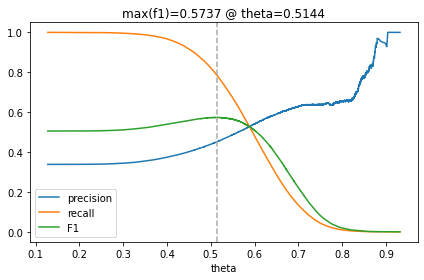

In [22]:
distances = 1 - np.array(calib_distances['distance'])
relevances = calib_distances['authorship']
precisions, recalls, thresholds = precision_recall_curve(relevances, distances, pos_label='S')
f1s = (2 * precisions * recalls) / (precisions + recalls)
f1s[np.isnan(f1s)] = 0.0

max_f1_idx = np.array(f1s).argmax() # index van hoogste f1
max_f1 = f1s[max_f1_idx] # hoogste f1
max_f1_th = thresholds[max_f1_idx] # threshold hoogste f1
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

In [23]:
calib_thresh = 1 - max_f1_th
calib_thresh

0.4856387747637826

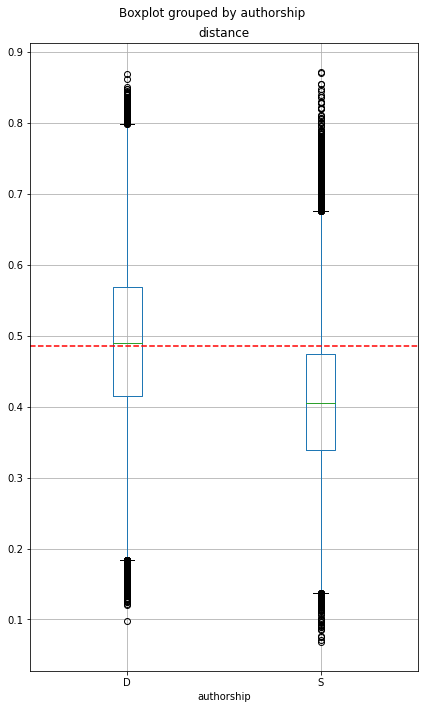

In [24]:
calib_distances.boxplot('distance', 'authorship', figsize=(6, 10))
plt.axhline(calib_thresh, c='red', ls='--')
plt.tight_layout();

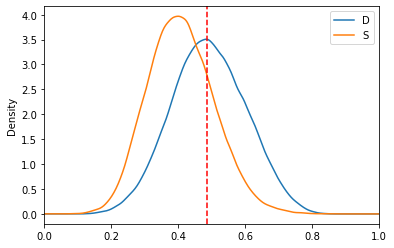

In [25]:
for grouper, group in calib_distances.groupby('authorship'):
    group['distance'].plot.kde(label=grouper);
plt.xlim((0, 1))
plt.axvline(calib_thresh, c='red', ls='--')
plt.legend();

##### Target

In [26]:
trg_df = segment_df[segment_df['title'].isin({'Limborch', 'Van Saladijn', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II'})]
trg_X = vectorizer.transform(trg_df['text']).toarray()
combos = pd.DataFrame(combinations(trg_df['title'].unique(), 2), columns=['title1', 'title2'])
combos['authorship'] = 'X'
combos

,title1,title2,authorship
0,Limborch,Roman der Lorreinen II,X
1,Limborch,Roman van Cassamus (kort),X
2,Limborch,Rose,X
3,Limborch,Van Saladijn,X
4,Roman der Lorreinen II,Roman van Cassamus (kort),X
5,Roman der Lorreinen II,Rose,X
6,Roman der Lorreinen II,Van Saladijn,X
7,Roman van Cassamus (kort),Rose,X
8,Roman van Cassamus (kort),Van Saladijn,X
9,Rose,Van Saladijn,X


In [27]:
trg_distances = []

for idx, row in combos.iterrows():
    AX = trg_X[trg_df['title'] == row['title1']]
    BX = trg_X[trg_df['title'] == row['title2']]
    
    for distance in scidist.cdist(AX, BX, metric='cosine').flatten():
        trg_distances.append((row['title1'], row['title2'], row['authorship'], distance))

trg_distances = pd.DataFrame(trg_distances, columns=['title1', 'title2', 'authorship', 'distance'])
trg_distances

,title1,title2,authorship,distance
0,Limborch,Roman der Lorreinen II,X,0.406936
1,Limborch,Roman der Lorreinen II,X,0.411378
2,Limborch,Roman der Lorreinen II,X,0.392149
3,Limborch,Roman der Lorreinen II,X,0.513125
4,Limborch,Roman der Lorreinen II,X,0.439716
...,...,...,...,...
8998,Rose,Van Saladijn,X,0.373281
8999,Rose,Van Saladijn,X,0.432668
9000,Rose,Van Saladijn,X,0.324146
9001,Rose,Van Saladijn,X,0.474312


In [28]:
distances = pd.concat([calib_distances, trg_distances])
distances

,title1,title2,authorship,distance
0,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.467202
1,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.551628
2,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.502511
3,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.574130
4,Alexanders geesten,Heymelijchede der heymelijcheit,S,0.383542
...,...,...,...,...
8998,Rose,Van Saladijn,X,0.373281
8999,Rose,Van Saladijn,X,0.432668
9000,Rose,Van Saladijn,X,0.324146
9001,Rose,Van Saladijn,X,0.474312


In [29]:
means = distances.groupby(['title1', 'title2'])['distance'].mean()
means = means.sort_values()
means.head(50)

title1                                      title2                                    
Brabantsche yeesten (B1-5)                  Van den derden Eduwaert                       0.292810
Roman der Lorreinen II                      Roman van Cassamus (kort)                     0.333002
Historie van Troyen                         Van den derden Eduwaert                       0.342441
Brabantsche yeesten (B1-5)                  Korte kroniek van Brabant (korte versie 1)    0.343924
Limborch                                    Roman der Lorreinen II                        0.345923
Korte kroniek van Brabant (korte versie 1)  Van den derden Eduwaert                       0.349510
Spiegel historiael (P1-P4)                  Van den derden Eduwaert                       0.353722
Roman der Lorreinen II                      Van Saladijn                                  0.353874
Alexanders geesten                          Van den derden Eduwaert                       0.356152
                      

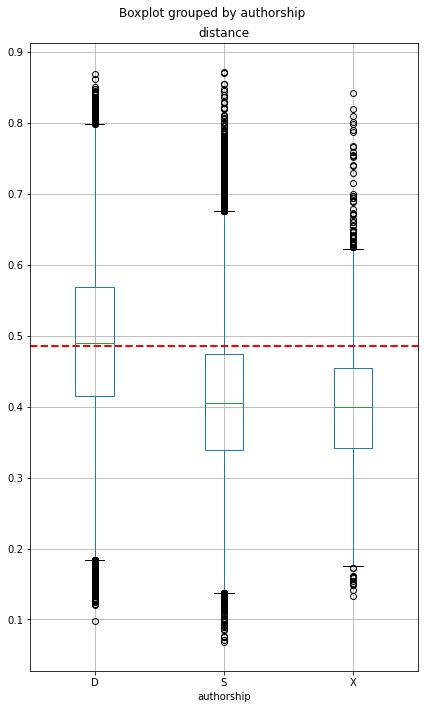

In [30]:
distances.boxplot('distance', 'authorship', figsize=(6, 10))
plt.axhline(calib_thresh, c='red', linewidth=2, ls='--')
plt.tight_layout();

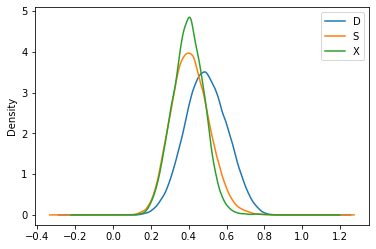

In [31]:
for grouper, group in distances.groupby('authorship'):
    group['distance'].plot.kde(label=grouper)
plt.legend();

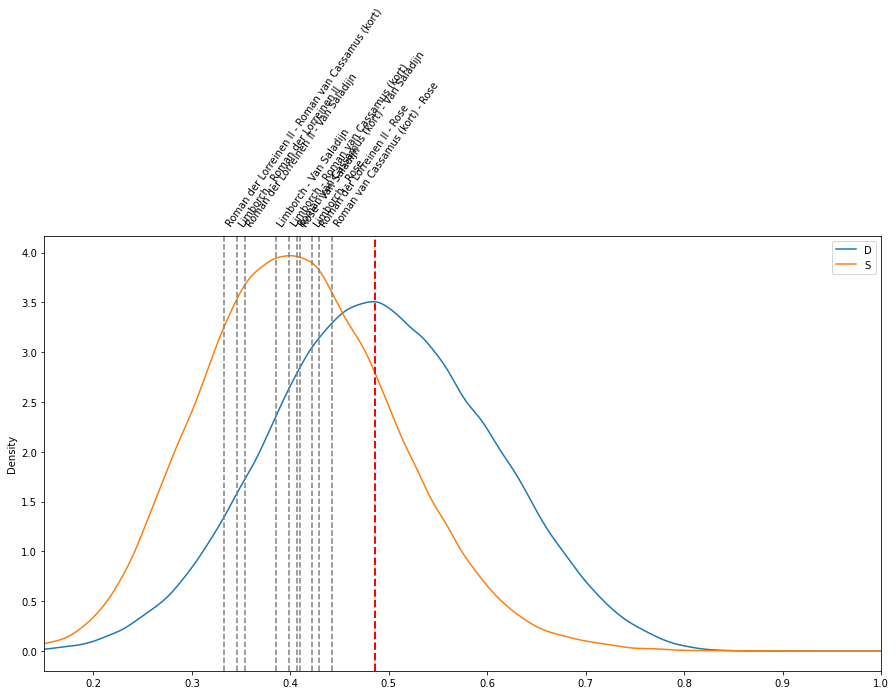

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
for grouper, group in distances.groupby('authorship'):
    if grouper == 'X':
        for m, d in group.groupby(['title1', 'title2'])['distance']:
            ax.axvline(d.mean(), c='grey', ls='--')
            plt.annotate(' - '.join(m), xy=[d.mean(), ax.get_ylim()[1]+0.1], annotation_clip=False, rotation=55)
    else:
        group['distance'].plot.kde(label=grouper, ax=ax)
plt.legend()
plt.axvline(calib_thresh, c='red', linewidth=2, ls='--')
plt.xlim(.15, 1);

## Networks

In [33]:
import re
from collections import Counter

import grapheme
import pandas as pd

import mpl_axes_aligner.align
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kendalltau
from tqdm import tqdm

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import seaborn as sb

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['title', 'genre', 'subgenre', 'date']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = df['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"

    p = figure(title='Embeddings',
               tools=TOOLS,
               plot_width=1000,
               plot_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], d['x'], d['y']):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="6pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

sub_df = segment_df[segment_df['subgenre'].isin({'Arthur', 'Karel', 'Ridder', 'Allegorie', 'Dier'})]
sub_df = sub_df[~sub_df['title'].isin({'Vlaamse Rose', 'Arturs doet', 'Merlijn-continuatie', 'Queeste van den Grale', 'Lancelot'})]
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
pca = PCA(n_components=15)
X = pca.fit_transform(BOW)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

scatterplot(X, sub_df, label_column='title', color_column='title')

In [37]:
sub_df = segment_df[segment_df['title'].isin({'Limborch', 'Van Saladijn', 'Rose', 'Roman van Cassamus (kort)',
                                              'Roman der Lorreinen II', 'Alexanders geesten', 'Historie van Troyen',
                                              'Grimbergse oorlog', 'Rijmkroniek van Woeringen'})]
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(sub_df['text']).toarray()
from sklearn.preprocessing import normalize
BOW = normalize(BOW)

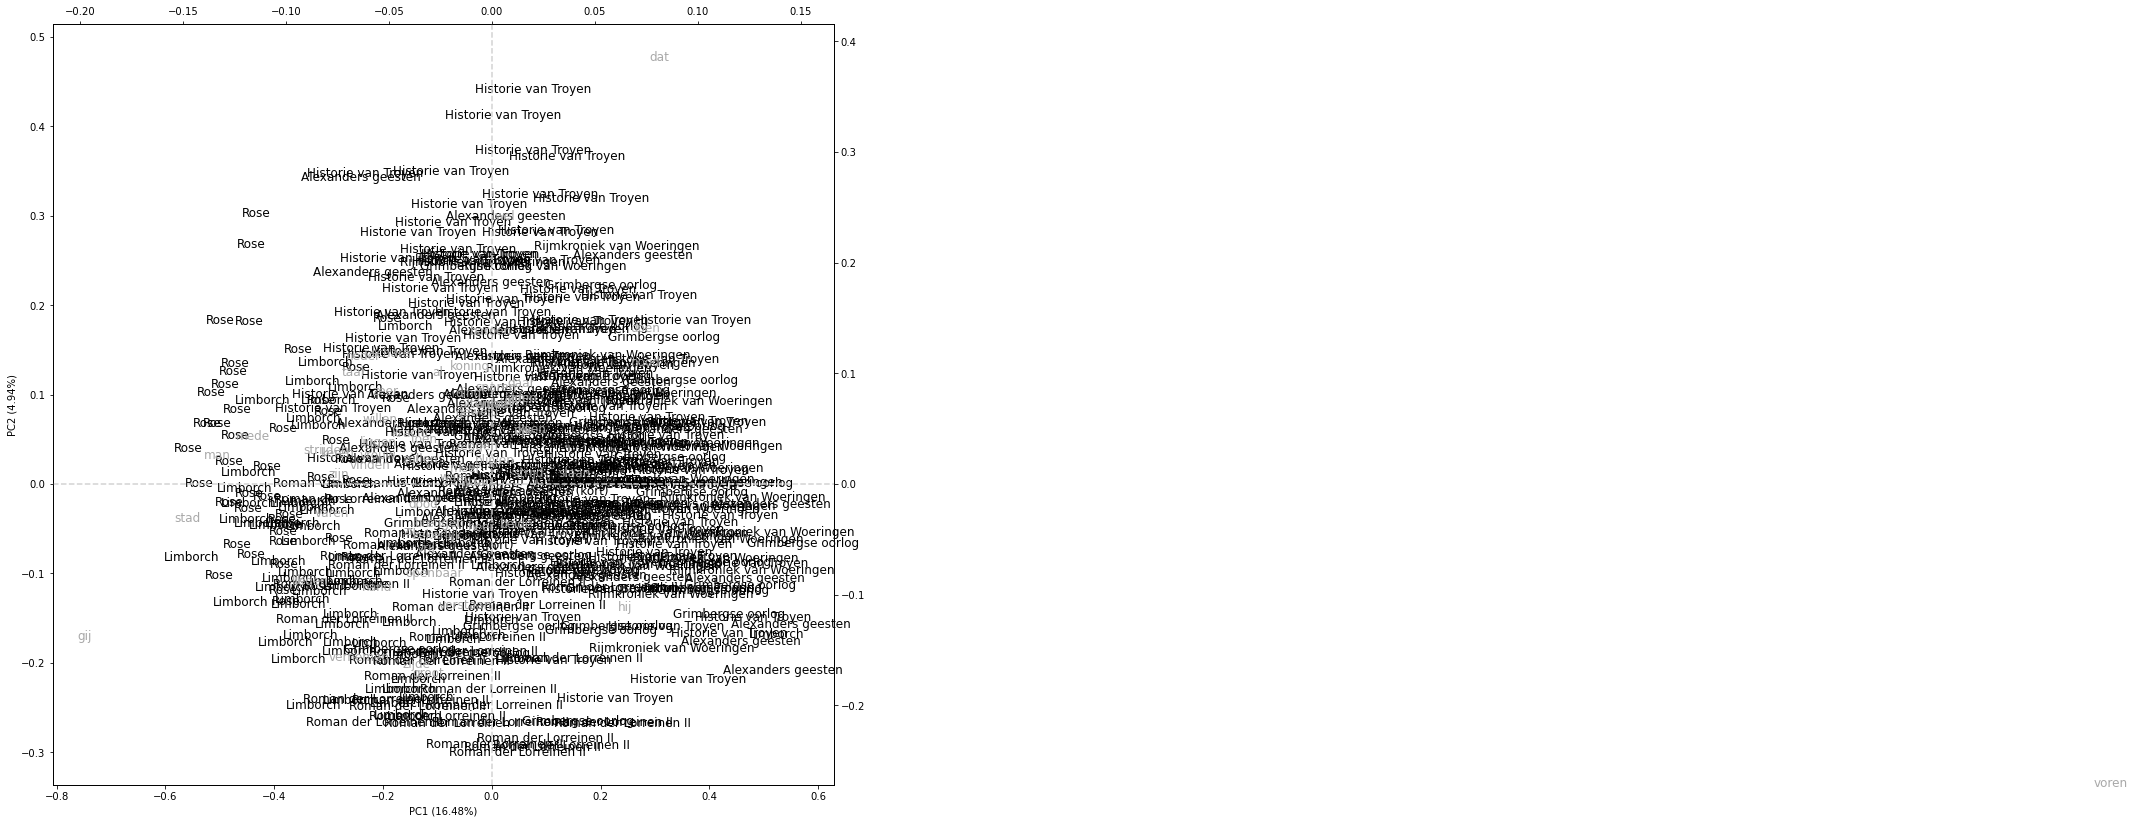

In [38]:
def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(14, 14))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, label in zip(x1, x2, labels):
        text_ax.text(p1, p2, label, ha='center', va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 60
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vectorizer.get_feature_names())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, sub_df['title'])

## Verification

In [52]:
epics = segment_df[segment_df['genre'] == 'Epiek'].copy().reindex()
epics.head(5)

,title,author,genre,date,subgenre,segment-idx,text
0,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,1,zeggen stad horen verdoorden goed doen verstaan waan geraakt maken lof af verkeren leren goed doen deugd mogen leren keren verstaan baraat bestaan vangen geeste volleesten verstaan slaan roek boek zien dag beschrijven leven lijf wijf maken geraakt oorlog togen zijn gedwaas hebben leven lieden geschieden wind vinden avontuur n(prop) n(prop) klein spel gevallen hun gestuinen waar jaar dwingen lang toe hoe bestaan goed voren horen zijn min moeten zoet geslacht macht voren geboren geweld behouden onderdaan ontvangen n(prop) prijs aardrijk rijk n(prop) vrij doorvechten kracht helft welk overslaan gaan land hand schip n(prop) jaar waar blijven beschrijven vrouw trouw wonder onkond zijn n(prop) zede hoofsheid zeggen liggen vader algader zekerlijk koninkrijk strijd tijd astronomie zien nigromansie toverij veel spel strijden tijd kemenade raad staan wanen weten list lieden geschieden zoeken vloeken n(prop) klein roeren vervoeren grond stond vijand land tijd strijd mare zijn n(prop) bij n(prop) wanen n(prop) n(prop) n(prop) tent land hand kemenade raad doen verstaan zullen n(prop) verstaan stond n(prop) vrij stond naamkond stad mede tijd strijden schier zij verstaan vergaan komen vernemen bevangen verstaan kind zenden ontvangen waan schande land winnen bekennen draak zaak koningin zin voren verkiezen kind minnen n(prop) na draak spreken geschieden zien n(prop) huis zaan doen zaal wel schouwen vrouw komen vernemen te zijn koningin minne zaan bevangen gewaar vaar heer eer raad staan geven leven weten staan gemak zaak belaas zijn voren geboren n(prop) doen spellen tellen worden vervaard nieuwmaar zijn zeer heer niet misschieden zin minne kind zenden oliempa zijn sproke breuk n(prop) huis gestade doen heer een mede stad gebaar zijn draak zaak schoon kroon hoofd verdoofd zijn sparen schoot groot waar haar uit overluid meer eer kind zenden tijd rijden land hand kleed gereed verede aarde ontwee
1,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,2,meer n(prop) dop eiselaan wel komen benemen toe toen openbaar zijn n(prop) zijn kind zenden omgang bedwang zekerlijk aardrijk kind vinden gaan koning dorren tijd dat zijn zullen al keren eer taal wel verstaan doen varen schare zeggen arbeid dat zijn vinden kind klerk kerk nochtan winnen bekend kind voren geboren kind zenden groot verschieten mede stad steen negeen lam komen vrouw rouw strijd tijd dag geliggen man verwinnen komen vernemen gaan zaan n(prop) n(prop) n(prop) zien keur natuur waar jaar leren keren aldus n(prop) wezen lezen klaar daar zien geschieden wel vel staan gezond meteen voorzien ongeval dal neder weder geschieden ontvlieden verstaan ontgaan jaar waar vader gader bedriegen lachen dood groot kemenade raad haar zijn winnen man vader gader ding koning algader vader aardrijk gelijk houden geweld onderdaan waan liggen verzien komen naam jaar waar kin min houden geweld gelijk kortelijk kindsheid stad lijf katijf geweld veld zwaard paard traag versagen banier vervaren staan doen vlieg wieg gigant band kind binden jaar waar niet iet doen raad doen mede zijn misbaren zin min jong sprong gaan bestaan koen doen dag zien geweld houden zaan gaan studeren verteren bleek gelijken waken zaak n(prop) zo verzien liggen vervaard waart nedergaan staan knie meteen gader vader oud geweld goed doen zeer meer schier lier niet raden vroed moed koen doen land vijand wijs prijs beduiden lieden dood goed altoos n(prop) heer deren klein rein zeer immermeer zullen al meer zeer fel wel beide hoofsheid serpent omtrent baraat vangen nederwaart staart oor verdoren knecht recht man kunnen goed vroed zij vrij zede stad tellen hel lieden miede goed moed verheffen geven goud menigvoud wijsheid edelheid alleen rein wijzen wijs miede lieden minne zin onrecht echt achter miede lieden komen verdoemen jeugd
2,Alexanders geesten,Jacob van Maerlant,Epiek,1400.0,Ridder,3,deugd vergeten weten miede lieden gena

In [53]:
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': 'word',
          'norm': 'l1',
          'ngram_range': (1, 1),
          'lowercase': False}

vectorizer = TfidfVectorizer(**params)
vectorizer.fit(epics['text'])
print(vectorizer.get_feature_names()[:30])
segment_X = vectorizer.transform(epics['text']).toarray()
segment_X.shape

['aan', 'al', 'alzo', 'bekennen', 'bij', 'blijven', 'brengen', 'daar', 'dag', 'dan', 'dat', 'de', 'deze', 'die', 'ding', 'doen', 'dood', 'dragen', 'eer', 'gaan', 'gereed', 'geschieden', 'geven', 'gij', 'goed', 'groot', 'hand', 'heer', 'hij', 'horen']


(2684, 100)

Optional: randomly select n segments for each work, so that the number of segments is the same for each work. If there are less segments present then n: keep them. In other words: you create an upper limit for the amount of segments that should be used.

In [54]:
def get_n_segments (epics, segments):
    sample = pd.DataFrame(columns = epics.columns)
    documents = epics['title'].unique()
    for document in documents:
        subset = epics.loc[epics['title'] == document]
        print(len(subset))
        if len(subset) < segments:
            print(f"There are only {len(subset)} sample(s) available for the subset of {document}, not {segments}.")
            sample = sample.append(subset)
        if len(subset) >= segments:
            subset = subset.sample(n=segments, random_state=1234)
            sample = sample.append(subset, ignore_index=True)
    sample = sample.reset_index()

    return sample

In [55]:
print(epics['title'].value_counts().median())
print(epics['title'].value_counts().mean())

8.0
21.821138211382113


In [56]:
epics = get_n_segments (epics, segments=100)

49
There are only 49 sample(s) available for the subset of Alexanders geesten, not 100.
42
There are only 42 sample(s) available for the subset of Arturs doet, not 100.
1
There are only 1 sample(s) available for the subset of Aubri de Borgengoen, not 100.
3
There are only 3 sample(s) available for the subset of Beatrijs, not 100.
4
There are only 4 sample(s) available for the subset of Bediedenisse van der missen, not 100.
1
There are only 1 sample(s) available for the subset of Beginsel der oorlogen van Luyck, not 100.
1
There are only 1 sample(s) available for the subset of Boec Exemplaer, not 100.
2
There are only 2 sample(s) available for the subset of Boec van den houte, not 100.
19
There are only 19 sample(s) available for the subset of Boec vander wraken, not 100.
13
There are only 13 sample(s) available for the subset of Borchgrave van Couchi, not 100.
3
There are only 3 sample(s) available for the subset of Borchgravinne van Vergi (1), not 100.
1
There are only 1 sample(s) ava

In [57]:
num_iter = 250
total_features = len(vectorizer.get_feature_names())
num_rnd_features = int(total_features * .5)

target_titles = ['Limborch', 'Van Saladijn', 'Rose', 'Roman van Cassamus (kort)', 'Roman der Lorreinen II']

for target_title in target_titles:
    targets = epics[epics['title'] == target_title]
    candidates = epics[epics['title'] != target_title]
    neighbors = Counter()
    for trg_idx in tqdm(list(targets.index), desc=target_title):
        for i in range(num_iter):
            feats = np.random.choice(total_features, num_rnd_features, replace=False)
            ax = segment_X[trg_idx, feats]
            sampled = candidates.groupby('title').sample(1)
            xx = segment_X[sampled.index][:, feats]
            distances = scidist.cdist([ax], xx, metric='cosine').flatten()
            idxs = distances.argsort()[:1]
            neighbors.update(sampled.iloc[idxs]['title'])
    print(target_title, ':', neighbors.most_common(5))
    
# 250 iteraties die je uitvoert voor elk stukje: hoe vaak stukje uit andere tekst de dichtste buur is

Limborch: 100%|████████████████████████████████████████████████████████████████████████| 75/75 [15:42<00:00, 12.57s/it]


Limborch : [('Leven van Sint Trudo (berijming)', 3623), ('Lapidarijs', 1396), ('Lantsloot van der Haghedochte', 1052), ('Riddere metter mouwen', 970), ('Lancelot', 570)]


Van Saladijn: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.33s/it]


Van Saladijn : [('Korte kroniek van Brabant (korte versie 1)', 73), ('Van den derden Eduwaert', 17), ('Spieghel der menscheliker behoudenesse', 16), ('Tien plaghen ende die tien ghebode', 14), ('Roman der Lorreinen I', 13)]


Rose: 100%|████████████████████████████████████████████████████████████████████████████| 49/49 [10:03<00:00, 12.32s/it]


Rose : [('Dystorie van Saladine', 492), ('Roman van Cassamus (kort)', 485), ('Segheliin van Jerusalem', 468), ('Grimbergse oorlog', 384), ('Jonathas ende Rosafiere', 376)]


Roman van Cassamus (kort): 100%|█████████████████████████████████████████████████████████| 6/6 [01:14<00:00, 12.34s/it]


Roman van Cassamus (kort) : [('Roman van Caesar', 104), ('Roman der Lorreinen II', 91), ('Rose', 85), ('Florimont', 59), ('Jans teesteye', 57)]


Roman der Lorreinen II: 100%|██████████████████████████████████████████████████████████| 34/34 [07:44<00:00, 13.66s/it]

Roman der Lorreinen II : [('Roman van Cassamus (kort)', 671), ('Roman van Caesar', 381), ('Roman der Lorreinen I', 348), ('Brabantsche yeesten (B1-5)', 341), ('Jans teesteye', 220)]
